* Oskar Szudzik 148245
* Krystian Moras 148243

This is a main notebook for our second project - board game detection.

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [3]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [4]:
mvideo = cv2.VideoCapture('data/dice.mp4')
if mvideo.isOpened():
    print('Video loaded')

mvideo_width = int(mvideo.get(3))
mvideo_height = int(mvideo.get(4))

print(mvideo_height, mvideo_width)

mvideo_fps = mvideo.get(cv2.CAP_PROP_FPS)
print(mvideo_fps)

Video loaded
1920 1080
29.965823788312317


Video

In [5]:
Video.from_file('data/dice.mp4')

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\x00\x01mdat\x00\x00\x00\x00\x03\x83\x0c…

Example frame

In [6]:
def clusterize(frame,k):
    Z = frame.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((frame.shape))
    return res2

In [17]:
mvideo = cv2.VideoCapture('data/dice.mp4')

In [ ]:
from matplotlib import animation
from IPython.display import clear_output
fig = plt.figure()
ax = plt.axes()

# animation function.  This is called sequentially
def animate(i):
    colors = ("red", "green", "blue")
    clear_output()
    plt.cla()
    ret, frame = mvideo.read()
    artists = []
    for i in range(3):
        histogram, bin_edges = np.histogram(frame[:, :, i], bins=256, range=(0, 256))
       # plt.plot(histogram, color=colors[i])
        artists.append(ax.plot(histogram,color=colors[i]))
    return artists

anim = animation.FuncAnimation(fig, animate, int(mvideo.get(cv2.CAP_PROP_FRAME_COUNT)))
anim.save('histogram_dice.mp4', writer = 'ffmpeg', fps = 30)

Keypoint detection

In [24]:
mvideo = cv2.VideoCapture('data/dice.mp4')
while(True):
    # Grab the latest image from the video feed
    ret, frame = mvideo.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret,thresholded = cv2.threshold(gray, 140, 170, cv2.THRESH_BINARY)

    # more info on setting params but imo good starting point
    params = cv2.SimpleBlobDetector_Params()
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(thresholded)
    keypoints
    im_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv2.imshow('frame',im_with_keypoints)

    res = cv2.waitKey(1)

    # Stop if the user presses "q"
    if res & 0xFF == ord('q'):
        break



error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:

ret, frame = mvideo.read()
imshow(frame)


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
ret,thresholded = cv2.threshold(gray, 140, 170, cv2.THRESH_BINARY)
imshow(thresholded)

dst = cv2.bitwise_not(thresholded)
imshow(dst)



In [120]:
params = cv2.SimpleBlobDetector_Params()
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(thresholded)
keypoints

(< cv2.KeyPoint 000001F1228F1380>,
 < cv2.KeyPoint 000001F1228F1620>,
 < cv2.KeyPoint 000001F1244123D0>,
 < cv2.KeyPoint 000001F124411BF0>,
 < cv2.KeyPoint 000001F124412BE0>,
 < cv2.KeyPoint 000001F124413FC0>,
 < cv2.KeyPoint 000001F124413A20>,
 < cv2.KeyPoint 000001F124413AB0>,
 < cv2.KeyPoint 000001F124413DB0>,
 < cv2.KeyPoint 000001F1244137E0>,
 < cv2.KeyPoint 000001F1244135A0>,
 < cv2.KeyPoint 000001F124411710>,
 < cv2.KeyPoint 000001F125F51EC0>,
 < cv2.KeyPoint 000001F125F51E90>,
 < cv2.KeyPoint 000001F125F534E0>,
 < cv2.KeyPoint 000001F125F53A80>,
 < cv2.KeyPoint 000001F125F53AB0>,
 < cv2.KeyPoint 000001F125F53BD0>)

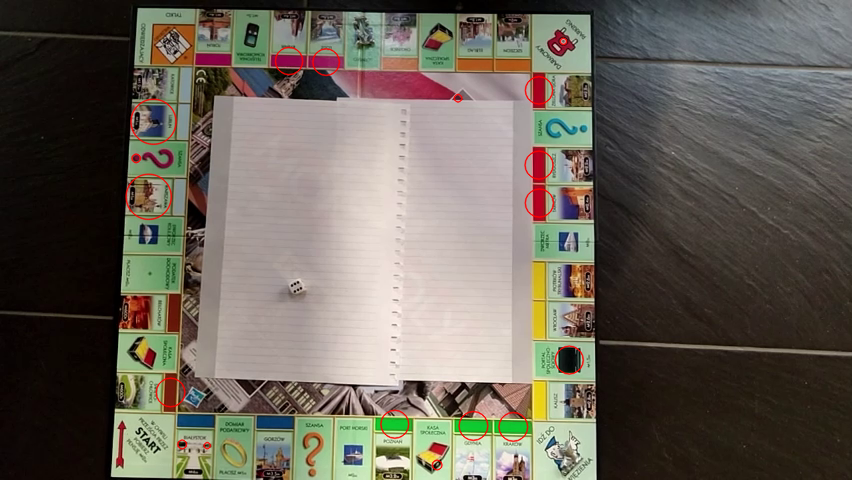

In [121]:
im_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imshow(im_with_keypoints)

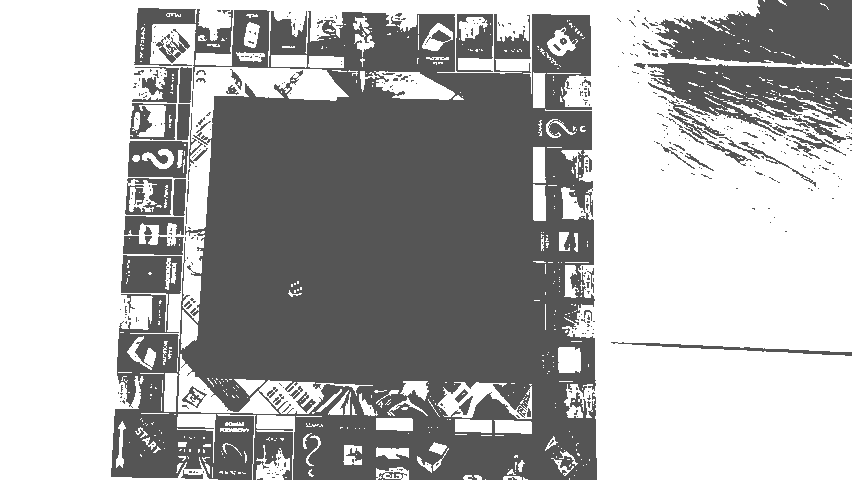

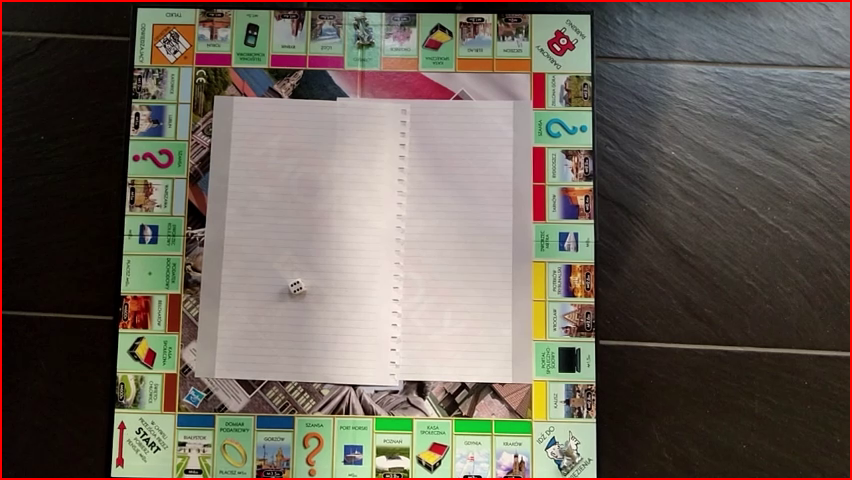

In [122]:

countours,hierarchy=cv2.findContours(dst,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# draw contours
for cnt in countours:
        cv2.drawContours(frame,[cnt],0,(0,0,255),2)
imshow(frame)

Not very effective 1/3

In [5]:
# mvideo_mog2 = cv2.VideoWriter('easy_mog2.avi', cv2.VideoWriter_fourcc(*'DIVX'), mvideo_fps, (mvideo_width, mvideo_height), 0)

# foreground_mog2 = cv2.createBackgroundSubtractorMOG2()

# mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
# while mvideo.isOpened():
#   ret, frame = mvideo.read()

#   if ret:
#     mvideo_mog2.write(foreground_mog2.apply(frame))
#   else:
#     break

# mvideo_mog2.release()

Recommended to run it from terminal 2/3

In [6]:
# !ffmpeg -hide_banner -loglevel error -i easy_mog2.avi -y easy_mog2.mp4

Not very effective 3/3

In [7]:
# Video.from_file('easy_mog2.mp4')

In [8]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()

def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

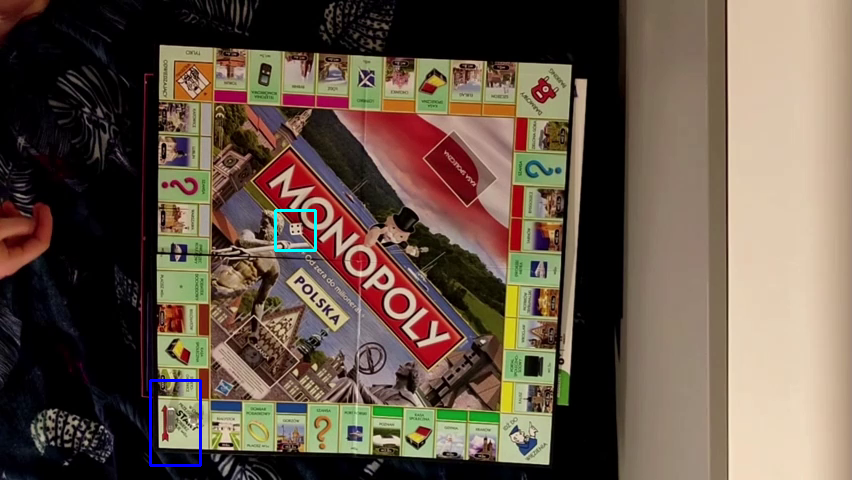

In [9]:
mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = mvideo.read()

player_bbox = (150, 380, 50, 85)
dice_bbox = (275, 210, 40, 40)

draw_bbox(frame, player_bbox, (255, 0, 0))
draw_bbox(frame, dice_bbox, (255, 255, 0))

imshow(frame)

In [10]:
mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = mvideo.read()

player_bbox = (150, 380, 50, 85)
dice_bbox = (275, 210, 40, 40)

player_tracker = create_tracker('MIL')
dice_tracker = create_tracker('MIL')

if player_tracker.init(frame, player_bbox):
  print('Player tracking algorithm initiated at point:', player_bbox)

if dice_tracker.init(frame, dice_bbox):
  print('Dice tracking algorithm initiated at point:', dice_bbox)

mvideo_track = cv2.VideoWriter('./easy_track_' + 'MIL' + '.avi', cv2.VideoWriter_fourcc(*'DIVX'), mvideo_fps, (mvideo_width, mvideo_height))

mvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)

while mvideo.isOpened():
    ret, frame = mvideo.read()

    if ret:
      ok, bbox = player_tracker.update(frame)
      if ok: draw_bbox(frame, bbox, (0, 255, 0))

      ok, bbox = dice_tracker.update(frame)
      if ok: draw_bbox(frame, bbox, (0, 255, 0))

      mvideo_track.write(frame)
    else:
        break

mvideo_track.release()

In [11]:
# !ffmpeg -hide_banner -loglevel error -i easy_track_MIL.avi -y easy_track_MIL.mp4

In [12]:
# Video.from_file('videos/3/video_track.mp4')

In [13]:
mvideo = cv2.VideoCapture('videos/3/easy.mp4')
if mvideo.isOpened():
    print('Video loaded')

mvideo_width = int(mvideo.get(3))
mvideo_height = int(mvideo.get(4))

print(mvideo_height, mvideo_width)

mvideo_fps = mvideo.get(cv2.CAP_PROP_FPS)
print(mvideo_fps)

Video loaded
480 852
30.0


In [14]:
object_detector = cv2.createBackgroundSubtractorMOG2()

while True:
    ret, frame = mvideo.read()
    player_bbox = (160, 390, 20, 50)
    dice_bbox = (280, 215, 30, 30)
    roi = frame[280: 310, 215: 80]

    mask = object_detector.apply(roi)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0))
        # cv2.drawContours(frame, [cnt], -1, (0, 255, 0

        imshow(frame)
        imshow(mask)

mvideo.release()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_wrap.cpp:1667: error: (-215:Assertion failed) !fixedSize() in function 'cv::_OutputArray::release'
